### Analysis of Bitcoin Transactions

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
# warnings.filterwarnings('ignore')

/kaggle/input/quandl/data.py
/kaggle/input/quandl/quandl.py
/kaggle/input/bitcoindataset/repository/colibri17-bitcoin-951ee4d/bitcoin.ipynb
/kaggle/input/bitcoindataset/repository/colibri17-bitcoin-951ee4d/README.md
/kaggle/input/bitcoin-blockchain/__results__.html
/kaggle/input/bitcoin-blockchain/__output__.json
/kaggle/input/bitcoin-blockchain/custom.css
/kaggle/input/bitcoin-blockchain/__results___files/__results___31_1.png
/kaggle/input/bitcoin-blockchain/__results___files/__results___47_1.png
/kaggle/input/bitcoin-blockchain/__results___files/__results___20_1.png
/kaggle/input/bitcoin-blockchain/__results___files/__results___59_1.png
/kaggle/input/bitcoin-blockchain/__results___files/__results___60_1.png
/kaggle/input/bitcoin-blockchain/__results___files/__results___35_1.png
/kaggle/input/bitcoin-blockchain/__results___files/__results___33_1.png
/kaggle/input/ml-blockchain/repository/charchitd-ML-in-Blockchain-876b97f/README.md
/kaggle/input/ml-blockchain/repository/charchitd-ML-i

In [2]:
# Importing all requirements
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import seaborn as sns
import datetime
import plotly.graph_objs as go
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as stt
import os
import shutil
import sklearn
from sklearn import preprocessing
import logging
import itertools

In [4]:
import tensorflow as tf
# Disable tf logger
tf.logging.set_verbosity(tf.logging.WARN)                                                                                     

# Pyplot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
  

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'


* Logger establishment/Customization

In [6]:


logger = logging.getLogger('bitcoin')
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s', datefmt='%m-%d %H:%M')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [7]:
from google.cloud import bigquery

# create a helper object for this dataset
client = bigquery.Client()

query = """ WITH time AS 
            (
                SELECT TIMESTAMP_MILLIS(timestamp) AS trans_time,
                    transaction_id
                FROM `bigquery-public-data.bitcoin_blockchain.transactions`
            )
            SELECT COUNT(transaction_id) AS transactions,
                EXTRACT(MONTH FROM trans_time) AS month,
                EXTRACT(YEAR FROM trans_time) AS year
            FROM time
            GROUP BY year, month 
            ORDER BY year, month
        """

# query = '''
# #standardSQL
# SELECT
#   *
# FROM (
#   SELECT
#     transaction_id,
#     COUNT(transaction_id) AS dup_transaction_count
#   FROM
#     `bigquery-public-data.bitcoin_blockchain.transactions`
#   GROUP BY
#     transaction_id)
# WHERE
#   dup_transaction_count > 1'''

query_job = client.query(query)

iterator = query_job.result(timeout=30)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
transactions = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

# Look at the first 10 headlines
transactions.head(10)
# active_project="bigquery-public-data",
#                                               dataset_name="bitcoin_blockchain")

Using Kaggle's public dataset BigQuery integration.


,transactions,month,year
0,2575,1,2009
1,3417,2,2009
2,3487,3,2009
3,3459,4,2009
4,3401,5,2009
5,2244,6,2009
6,1930,7,2009
7,1570,8,2009
8,2170,9,2009
9,2139,10,2009


(<matplotlib.axes._subplots.AxesSubplot at 0x7f59d97318d0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59d7655eb8>,
       dtype=object))

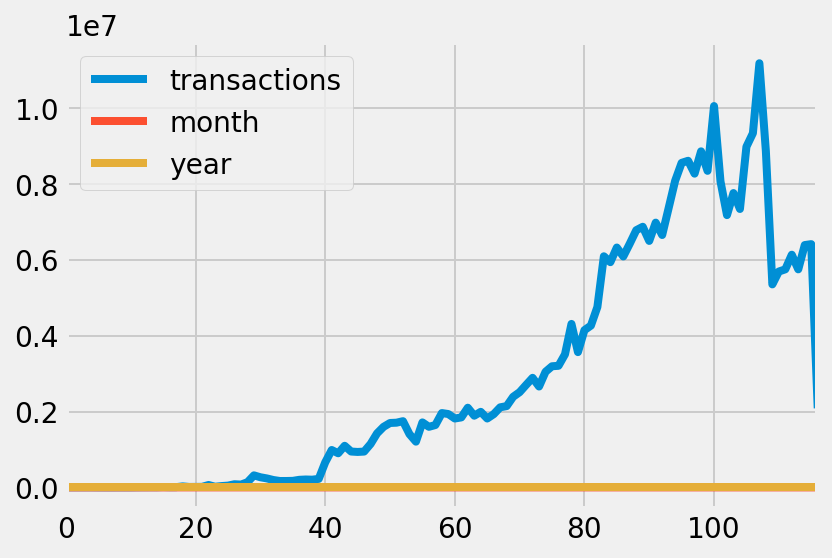

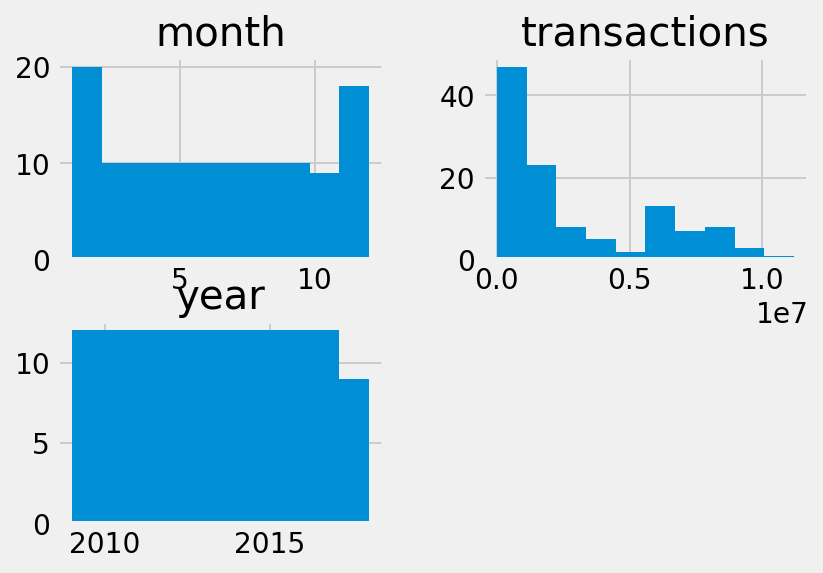

In [10]:
transactions.plot(), transactions.hist()

In [11]:
transactions.shape

(117, 3)

In [12]:
! pip install --upgrade google-cloud-bigquery

     |████████████████████████████████| 153kB 5.8MB/s eta 0:00:01
  Found existing installation: google-cloud-bigquery 1.12.1
    Uninstalling google-cloud-bigquery-1.12.1:
      Successfully uninstalled google-cloud-bigquery-1.12.1


In [13]:
# query = """ WITH time AS 
#             (
#                 SELECT TIMESTAMP_MILLIS(timestamp) AS trans_time,
#                     transaction_id
#                 FROM `bigquery-public-data.bitcoin_blockchain.transactions`
#             )
#             SELECT COUNT(transaction_id) AS transactions,
#                 EXTRACT(MONTH FROM trans_time) AS month,
#                 EXTRACT(YEAR FROM trans_time) AS year
#             FROM time
#             GROUP BY year, month 
#             ORDER BY year, month
#         """

# # note that max_gb_scanned is set to 21, rather than 1
# transactions_per_month = bt_data.query_to_pandas_safe(query, max_gb_scanned=21)

In [14]:
transactions.tail()

,transactions,month,year
112,6138957,5,2018
113,5752514,6,2018
114,6393536,7,2018
115,6417764,8,2018
116,2087279,9,2018


In [15]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(transactions,train_size = 0.5,random_state = 42 )

In [16]:
test_orig = test.copy()
train_orig = train.copy()

In [17]:
train.columns, test.columns

(Index(['transactions', 'month', 'year'], dtype='object'),
 Index(['transactions', 'month', 'year'], dtype='object'))

In [18]:
test.dtypes, train.dtypes

(transactions    int64
 month           int64
 year            int64
 dtype: object, transactions    int64
 month           int64
 year            int64
 dtype: object)

In [19]:
#  Shapes 
train.shape, test.shape


((58, 3), (59, 3))

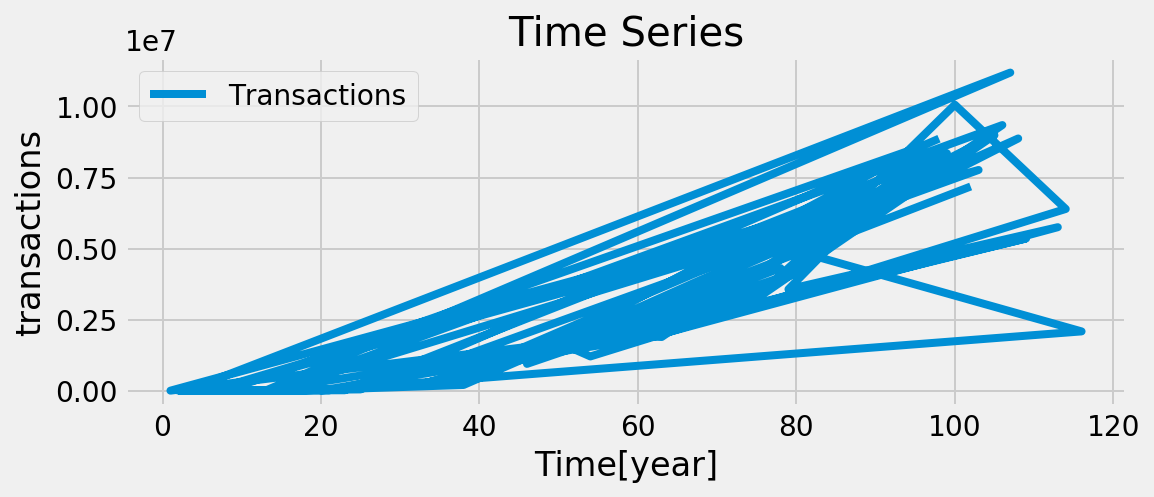

In [20]:
df = train.drop('year', 1)

ts = df['transactions']

plt.figure(figsize = (8,3))

plt.plot(ts, label = 'Transactions')
plt.title('Time Series')
plt.xlabel("Time[year]")
plt.ylabel("transactions")

plt.legend(loc = 'best')

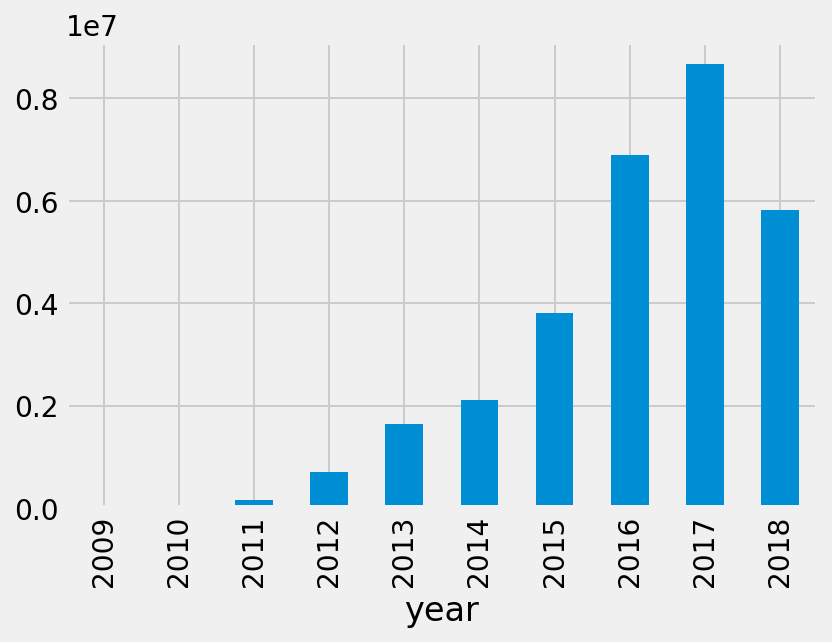

In [21]:
transactions.groupby('year')['transactions'].mean().plot.bar()

In [22]:
# KNN Implementations
# importing required libraries
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# # read the train and test dataset
# train_da
# test_data = pd.read_csv('test-data.csv')

# # shape of the dataset
# print('Shape of training data :',train_data.shape)
# print('Shape of testing data :',test_data.shape)

# Now, we need to predict the missing target variable in the test data
# target variable - Survived

# seperate the independent and target variable on training data
train_x = train.drop(columns=['transactions'],axis=1)
train_y = train['transactions']

# seperate the independent and target variable on testing data
test_x = test.drop(columns=['transactions'],axis=1)
test_y = test['transactions']

'''
Create the object of the K-Nearest Neighbor model
You can also add other parameters and test your code here
Some parameters are : n_neighbors, leaf_size
Documentation of sklearn K-Neighbors Classifier: 

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

 '''
model = KNeighborsClassifier()  

# fit the model with the training data
model.fit(train_x,train_y)

# Number of Neighbors used to predict the target
print('\nThe number of neighbors used to predict the target : ',model.n_neighbors)

# predict the target on the train dataset
predict_train = model.predict(train_x)
print('\nTarget on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(train_y,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = model.predict(test_x)
print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(test_y,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)


The number of neighbors used to predict the target :  5

Target on train data [5356201    5398    1930 5356201  208362    3417 4268853    3417    1930
   47168 3569102    1930 3195618 5752514 5752514  986424  203391 1206876
  194707 1645247 1425459 5752514 3569102 3569102    6678  944891  208362
 5356201  944891 1890902    2170 5356201  944891 1699308 5356201   47168
    1930 6393536    3417  986424    2170    3417   13185 6431712 3195618
 2087279 1846258 3050358 1961108 2087279    1930 1425459  944891 4268853
    3417 3569102  203391 6393536]
accuracy_score on train dataset :  0.10344827586206896
Target on test data [  13185    1930  317482    6678    2170 3050358 1425459 4268853   47168
    2170  203391    5398 2703958 2087279    1930    3417 1699308 5752514
 1890902 5752514 1645247 4313056 2087279    3417    3459 1645247    6678
    5751  194707    2170 5356201  986424 3569102    1930 1817513   17142
    2170   13185 5356201 1206876    6678   14386 1935103    1930 1817513
 1206876 

_________________________________________________________________________________________________________________________________________
## Data Importing


In [23]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as PathEffects
import matplotlib.pylab as pylab
import numpy as np
import pandas as pd
import itertools
from sklearn.metrics import  confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import time
import seaborn as sns
from keras import utils, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.losses import binary_crossentropy

Using TensorFlow backend.


In [24]:
miner_limit = 5000
non_miner_limit = 5000

In [25]:
query1 ='''
WITH 
output_ages AS (
  SELECT
    ARRAY_TO_STRING(outputs.addresses,',') AS output_ages_address,
    MIN(block_timestamp_month) AS output_month_min,
    MAX(block_timestamp_month) AS output_month_max
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  GROUP BY output_ages_address
)
,input_ages AS (
  SELECT
    ARRAY_TO_STRING(inputs.addresses,',') AS input_ages_address,
    MIN(block_timestamp_month) AS input_month_min,
    MAX(block_timestamp_month) AS input_month_max
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(inputs) AS inputs
  GROUP BY input_ages_address
)
,output_monthly_stats AS (
  SELECT
    ARRAY_TO_STRING(outputs.addresses,',') AS output_monthly_stats_address, 
    COUNT(DISTINCT block_timestamp_month) AS output_active_months,
    COUNT(outputs) AS total_tx_output_count,
    SUM(value) AS total_tx_output_value,
    AVG(value) AS mean_tx_output_value,
    STDDEV(value) AS stddev_tx_output_value,
    COUNT(DISTINCT(`hash`)) AS total_output_tx,
    SUM(value)/COUNT(block_timestamp_month) AS mean_monthly_output_value,
    COUNT(outputs.addresses)/COUNT(block_timestamp_month) AS mean_monthly_output_count
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  GROUP BY output_monthly_stats_address
)
,input_monthly_stats AS (
  SELECT
    ARRAY_TO_STRING(inputs.addresses,',') AS input_monthly_stats_address, 
    COUNT(DISTINCT block_timestamp_month) AS input_active_months,
    COUNT(inputs) AS total_tx_input_count,
    SUM(value) AS total_tx_input_value,
    AVG(value) AS mean_tx_input_value,
    STDDEV(value) AS stddev_tx_input_value,
    COUNT(DISTINCT(`hash`)) AS total_input_tx,
    SUM(value)/COUNT(block_timestamp_month) AS mean_monthly_input_value,
    COUNT(inputs.addresses)/COUNT(block_timestamp_month) AS mean_monthly_input_count
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(inputs) AS inputs
  GROUP BY input_monthly_stats_address
)
,output_idle_times AS (
  SELECT
    address AS idle_time_address,
    AVG(idle_time) AS mean_output_idle_time,
    STDDEV(idle_time) AS stddev_output_idle_time
  FROM
  (
    SELECT 
      event.address,
      IF(prev_block_time IS NULL, NULL, UNIX_SECONDS(block_time) - UNIX_SECONDS(prev_block_time)) AS idle_time
    FROM (
      SELECT
        ARRAY_TO_STRING(outputs.addresses,',') AS address, 
        block_timestamp AS block_time,
        LAG(block_timestamp) OVER (PARTITION BY ARRAY_TO_STRING(outputs.addresses,',') ORDER BY block_timestamp) AS prev_block_time
      FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
    ) AS event
    WHERE block_time != prev_block_time
  )
  GROUP BY address
)
,input_idle_times AS (
  SELECT
    address AS idle_time_address,
    AVG(idle_time) AS mean_input_idle_time,
    STDDEV(idle_time) AS stddev_input_idle_time
  FROM
  (
    SELECT 
      event.address,
      IF(prev_block_time IS NULL, NULL, UNIX_SECONDS(block_time) - UNIX_SECONDS(prev_block_time)) AS idle_time
    FROM (
      SELECT
        ARRAY_TO_STRING(inputs.addresses,',') AS address, 
        block_timestamp AS block_time,
        LAG(block_timestamp) OVER (PARTITION BY ARRAY_TO_STRING(inputs.addresses,',') ORDER BY block_timestamp) AS prev_block_time
      FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(inputs) AS inputs
    ) AS event
    WHERE block_time != prev_block_time
  )
  GROUP BY address
)
--,miners AS (
--)

(SELECT
  TRUE AS is_miner,
  output_ages_address AS address,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_month_min,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) AS output_month_max,
  UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_month_min,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS input_month_max,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_active_time,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_active_time,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS io_max_lag,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS io_min_lag,
  output_monthly_stats.output_active_months,
  output_monthly_stats.total_tx_output_count,
  output_monthly_stats.total_tx_output_value,
  output_monthly_stats.mean_tx_output_value,
  output_monthly_stats.stddev_tx_output_value,
  output_monthly_stats.total_output_tx,
  output_monthly_stats.mean_monthly_output_value,
  output_monthly_stats.mean_monthly_output_count,
  input_monthly_stats.input_active_months,
  input_monthly_stats.total_tx_input_count,
  input_monthly_stats.total_tx_input_value,
  input_monthly_stats.mean_tx_input_value,
  input_monthly_stats.stddev_tx_input_value,
  input_monthly_stats.total_input_tx,
  input_monthly_stats.mean_monthly_input_value,
  input_monthly_stats.mean_monthly_input_count,
  output_idle_times.mean_output_idle_time,
  output_idle_times.stddev_output_idle_time,
  input_idle_times.mean_input_idle_time,
  input_idle_times.stddev_input_idle_time
FROM
  output_ages, output_monthly_stats, output_idle_times,
  input_ages,  input_monthly_stats, input_idle_times
WHERE TRUE
  AND output_ages.output_ages_address = output_monthly_stats.output_monthly_stats_address
  AND output_ages.output_ages_address = output_idle_times.idle_time_address
  AND output_ages.output_ages_address = input_monthly_stats.input_monthly_stats_address
  AND output_ages.output_ages_address = input_ages.input_ages_address
  AND output_ages.output_ages_address = input_idle_times.idle_time_address
  AND output_ages.output_ages_address IN
(
  SELECT 
    ARRAY_TO_STRING(outputs.addresses,',') AS miner
  FROM 
  `bigquery-public-data.crypto_bitcoin.blocks` AS blocks,
  `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  WHERE blocks.hash = transactions.block_hash 
    AND is_coinbase IS TRUE
    AND ( FALSE
      --
      -- miner signatures from https://en.bitcoin.it/wiki/Comparison_of_mining_pools
      --
      OR coinbase_param LIKE '%4d696e656420627920416e74506f6f6c%' --AntPool
      OR coinbase_param LIKE '%2f42434d6f6e737465722f%' --BCMonster
      --BitcoinAffiliateNetwork
      OR coinbase_param LIKE '%4269744d696e746572%' --BitMinter
      --BTC.com
      --BTCC Pool
      --BTCDig
      OR coinbase_param LIKE '%2f7374726174756d2f%' --Btcmp
      --btcZPool.com
      --BW Mining
      OR coinbase_param LIKE '%456c6967697573%' --Eligius
      --F2Pool
      --GHash.IO
      --Give Me COINS
      --Golden Nonce Pool
      OR coinbase_param LIKE '%2f627261766f2d6d696e696e672f%' --Bravo Mining
      OR coinbase_param LIKE '%4b616e6f%' --KanoPool
      --kmdPool.org
      OR coinbase_param LIKE '%2f6d6d706f6f6c%' --Merge Mining Pool
      --MergeMining
      --Multipool
      --P2Pool
      OR coinbase_param LIKE '%2f736c7573682f%' --Slush Pool
      --ZenPool.org
    )
  GROUP BY miner
  HAVING COUNT(1) >= 20 
)
LIMIT {})
UNION ALL
(SELECT
  FALSE AS is_miner,
  output_ages_address AS address,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_month_min,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) AS output_month_max,
  UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_month_min,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS input_month_max,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_active_time,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_active_time,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS io_max_lag,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS io_min_lag,
  output_monthly_stats.output_active_months,
  output_monthly_stats.total_tx_output_count,
  output_monthly_stats.total_tx_output_value,
  output_monthly_stats.mean_tx_output_value,
  output_monthly_stats.stddev_tx_output_value,
  output_monthly_stats.total_output_tx,
  output_monthly_stats.mean_monthly_output_value,
  output_monthly_stats.mean_monthly_output_count,
  input_monthly_stats.input_active_months,
  input_monthly_stats.total_tx_input_count,
  input_monthly_stats.total_tx_input_value,
  input_monthly_stats.mean_tx_input_value,
  input_monthly_stats.stddev_tx_input_value,
  input_monthly_stats.total_input_tx,
  input_monthly_stats.mean_monthly_input_value,
  input_monthly_stats.mean_monthly_input_count,
  output_idle_times.mean_output_idle_time,
  output_idle_times.stddev_output_idle_time,
  input_idle_times.mean_input_idle_time,
  input_idle_times.stddev_input_idle_time
FROM
  output_ages, output_monthly_stats, output_idle_times,
  input_ages,  input_monthly_stats, input_idle_times
WHERE TRUE
  AND output_ages.output_ages_address = output_monthly_stats.output_monthly_stats_address
  AND output_ages.output_ages_address = output_idle_times.idle_time_address
  AND output_ages.output_ages_address = input_monthly_stats.input_monthly_stats_address
  AND output_ages.output_ages_address = input_ages.input_ages_address
  AND output_ages.output_ages_address = input_idle_times.idle_time_address
  AND output_ages.output_ages_address NOT IN
(
  SELECT 
    ARRAY_TO_STRING(outputs.addresses,',') AS miner
  FROM 
  `bigquery-public-data.crypto_bitcoin.blocks` AS blocks,
  `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  WHERE blocks.hash = transactions.block_hash 
    AND is_coinbase IS TRUE
    AND ( FALSE
      --
      -- miner signatures from https://en.bitcoin.it/wiki/Comparison_of_mining_pools
      --
      OR coinbase_param LIKE '%4d696e656420627920416e74506f6f6c%' --AntPool
      OR coinbase_param LIKE '%2f42434d6f6e737465722f%' --BCMonster
      --BitcoinAffiliateNetwork
      OR coinbase_param LIKE '%4269744d696e746572%' --BitMinter
      --BTC.com
      --BTCC Pool
      --BTCDig
      OR coinbase_param LIKE '%2f7374726174756d2f%' --Btcmp
      --btcZPool.com
      --BW Mining
      OR coinbase_param LIKE '%456c6967697573%' --Eligius
      --F2Pool
      --GHash.IO
      --Give Me COINS
      --Golden Nonce Pool
      OR coinbase_param LIKE '%2f627261766f2d6d696e696e672f%' --Bravo Mining
      OR coinbase_param LIKE '%4b616e6f%' --KanoPool
      --kmdPool.org
      OR coinbase_param LIKE '%2f6d6d706f6f6c%' --Merge Mining Pool
      --MergeMining
      --Multipool
      --P2Pool
      OR coinbase_param LIKE '%2f736c7573682f%' --Slush Pool
      --ZenPool.org
    )
  GROUP BY miner
  HAVING COUNT(1) >= 20 
)
LIMIT {})
'''.format(miner_limit, non_miner_limit)

In [26]:
bt_data = client.query(query1).to_dataframe()

In [27]:
bt_data.head()

,is_miner,address,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,...,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,stddev_output_idle_time,mean_input_idle_time,stddev_input_idle_time
0,False,1PX2naAvKoQNgRrKLiCh5o3XhmL3619MHZ,1556668800,1561939200,1556668800,1561939200,5270400,5270400,0,0,...,9282,546,0.000000e+00,12,546,1.0,312664.062500,4.685163e+05,5.002636e+05,5.758922e+05
1,False,1BitPRKKj8TbaEKRnPL6ZWfCr3A1jfTfQX,1477958400,1491004800,1477958400,1491004800,13046400,13046400,0,0,...,47748240,757908.571428571,5.452178e+05,62,757908.571428571,1.0,219759.951613,6.392662e+05,2.231315e+05,6.439326e+05
2,False,186HuRTFRmPAK7ojG9ErEworohWLs1Avi2,1551398400,1564617600,1551398400,1561939200,13219200,10540800,2678400,0,...,332110246,33211024.6,2.915317e+07,10,33211024.6,1.0,923262.533333,1.549327e+06,1.346069e+06,1.971878e+06
3,False,1HnuNt5Lh6T6AKphw8d6kbiQczdPdDTmT8,1448928000,1491004800,1448928000,1491004800,42076800,42076800,0,0,...,1804140000,22837215.189873418,5.386287e+07,78,22837215.189873418,1.0,614214.277778,1.657860e+06,5.976120e+05,1.604882e+06
4,False,1H2Z4ncdTXvFtReQNjxaZcmxpp7hfL2XzF,1556668800,1556668800,1556668800,1556668800,0,0,0,0,...,11379444,632191.333333333,2.100649e+03,18,632191.333333333,1.0,944.000000,1.071258e+03,9.440000e+02,1.071258e+03


### Data Pre-Processing and Cleaning...

In [28]:
bt_data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False).head(7)



,is_miner,address,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,...,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,stddev_output_idle_time,mean_input_idle_time,stddev_input_idle_time
0,False,1PX2naAvKoQNgRrKLiCh5o3XhmL3619MHZ,1556668800,1561939200,1556668800,1561939200,5270400,5270400,0,0,...,9282,546,0.000000e+00,12,546,1.0,312664.062500,4.685163e+05,5.002636e+05,5.758922e+05
1,False,1BitPRKKj8TbaEKRnPL6ZWfCr3A1jfTfQX,1477958400,1491004800,1477958400,1491004800,13046400,13046400,0,0,...,47748240,757908.571428571,5.452178e+05,62,757908.571428571,1.0,219759.951613,6.392662e+05,2.231315e+05,6.439326e+05
2,False,186HuRTFRmPAK7ojG9ErEworohWLs1Avi2,1551398400,1564617600,1551398400,1561939200,13219200,10540800,2678400,0,...,332110246,33211024.6,2.915317e+07,10,33211024.6,1.0,923262.533333,1.549327e+06,1.346069e+06,1.971878e+06
3,False,1HnuNt5Lh6T6AKphw8d6kbiQczdPdDTmT8,1448928000,1491004800,1448928000,1491004800,42076800,42076800,0,0,...,1804140000,22837215.189873418,5.386287e+07,78,22837215.189873418,1.0,614214.277778,1.657860e+06,5.976120e+05,1.604882e+06
4,False,1H2Z4ncdTXvFtReQNjxaZcmxpp7hfL2XzF,1556668800,1556668800,1556668800,1556668800,0,0,0,0,...,11379444,632191.333333333,2.100649e+03,18,632191.333333333,1.0,944.000000,1.071258e+03,9.440000e+02,1.071258e+03
5,False,1Q1czi9kDvdbrvtjtnfp73Uxm5en1hx8Y7,1406851200,1509494400,1406851200,1509494400,102643200,102643200,0,0,...,7750750,51671.666666667,1.098895e+05,53,51671.666666667,1.0,628604.246914,1.712229e+06,2.078119e+06,4.476430e+06
6,False,194JVEbrcCgu5eVLskRUSzzenDf8WLCTzx,1546300800,1561939200,1546300800,1561939200,15638400,15638400,0,0,...,646884745,35938041.388888889,6.270052e+07,18,35938041.388888889,1.0,818596.894737,5.917871e+05,9.147859e+05,7.219928e+05


In [29]:
print("Shape of data: ",bt_data.shape)

Shape of data:  (10000, 30)


In [30]:
bt_data.describe()

,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,output_active_months,total_tx_output_count,...,mean_monthly_output_count,input_active_months,total_tx_input_count,stddev_tx_input_value,total_input_tx,mean_monthly_input_count,mean_output_idle_time,stddev_output_idle_time,mean_input_idle_time,stddev_input_idle_time
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,10000.000000,...,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.0,1.000000e+04,8.083000e+03,1.000000e+04,7.602000e+03
mean,1.432197e+09,1.465164e+09,1.436809e+09,1.471037e+09,3.296721e+07,3.422827e+07,-5.873377e+06,-4.612317e+06,8.189200,99.387100,...,1.0,5.481000,96.308900,1.057369e+08,27.533800,1.0,1.409842e+06,2.389552e+06,5.218313e+06,7.126849e+06
std,6.773822e+07,5.867101e+07,6.675754e+07,5.921738e+07,4.176787e+07,4.393810e+07,2.957923e+07,1.554762e+07,9.187254,367.245734,...,0.0,6.223674,362.162039,9.113356e+08,191.285769,0.0,4.255643e+06,4.397153e+06,1.159142e+07,1.156535e+07
min,1.291162e+09,1.296518e+09,1.296518e+09,1.296518e+09,0.000000e+00,0.000000e+00,-1.973376e+08,-1.973376e+08,1.000000,2.000000,...,1.0,1.000000,2.000000,0.000000e+00,2.000000,1.0,1.800000e+01,7.071068e+00,1.200000e+01,6.717514e+01
25%,1.383264e+09,1.417392e+09,1.385856e+09,1.422749e+09,2.592000e+06,2.592000e+06,-5.097600e+06,-2.678400e+06,2.000000,3.000000,...,1.0,2.000000,3.000000,1.422818e+06,3.000000,1.0,1.605210e+05,2.916367e+05,4.326393e+05,7.262088e+05
50%,1.406851e+09,1.470010e+09,1.417392e+09,1.480550e+09,1.581120e+07,1.321920e+07,0.000000e+00,0.000000e+00,5.000000,29.000000,...,1.0,3.000000,27.000000,7.205690e+06,6.000000,1.0,4.407730e+05,9.077530e+05,1.492905e+06,2.462543e+06
75%,1.496275e+09,1.512086e+09,1.501546e+09,1.514765e+09,4.752000e+07,5.244480e+07,0.000000e+00,0.000000e+00,11.000000,92.000000,...,1.0,7.000000,88.000000,3.393444e+07,19.000000,1.0,1.153983e+06,2.519757e+06,4.807225e+06,7.958512e+06
max,1.564618e+09,1.564618e+09,1.564618e+09,1.564618e+09,2.577312e+08,2.604096e+08,2.049408e+08,0.000000e+00,88.000000,18677.000000,...,1.0,77.000000,18655.000000,4.321428e+10,13977.000000,1.0,1.297071e+08,7.392019e+07,1.483353e+08,1.323675e+08


### Feature Scalling... extracting features and balanced the dataset

In [31]:
bt_features = bt_data.drop(labels = ['is_miner', 'address'], axis =1)
target_attr = bt_data['is_miner'].values
indices = range(len(bt_features))

* #### Splitting into Training and Testing dataset for training

In [32]:
X = bt_data.iloc[:, 0:4].values
y = bt_data.iloc[:, 4].values

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(bt_features, target_attr, indices,  test_size = 0.4)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [34]:
# Shape of splited data
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (6000, 28)
X_test shape:  (4000, 28)
y_train shape:  (6000,)
y_test shape:  (4000,)


In [35]:
X_test.head()

,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,output_active_months,total_tx_output_count,...,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,stddev_output_idle_time,mean_input_idle_time,stddev_input_idle_time
2995,1380585600,1420070400,1380585600,1480550400,39484800,99964800,-60480000,0,5,63,...,1183575247,18786908.682539683,9.482317e+06,13,18786908.682539683,1.0,6.320909e+05,4.010791e+06,9.082062e+06,1.136484e+07
5540,1459468800,1459468800,1459468800,1459468800,0,0,0,0,1,2,...,23335532,11667766,8.301994e+06,2,11667766,1.0,1.923000e+03,NaN,4.238600e+04,NaN
3217,1385856000,1417392000,1385856000,1454284800,31536000,68428800,-36892800,0,10,98,...,449064604,4582291.87755102,2.337656e+06,38,4582291.87755102,1.0,3.191686e+05,1.026397e+06,1.823209e+06,7.987636e+06
1219,1309478400,1320105600,1314835200,1320105600,10627200,5270400,0,-5356800,5,56,...,5627486510,102317936.545454545,1.019490e+08,3,102317936.545454545,1.0,2.166298e+05,5.455056e+05,2.995280e+06,2.761403e+06
6069,1488326400,1491004800,1488326400,1491004800,2678400,2678400,0,0,2,3,...,45591,15197,1.284618e+04,3,15197,1.0,1.213954e+06,1.109144e+06,1.183876e+06,1.126347e+06


In [36]:
def Data_Clean():
  print("Processing...")
# Train
  X_train.isnull().sum()
  X_train.info()


# Test
  X_test.isnull().sum()
  X_test.info()
  

Data_Clean()
print("Cleaning over..")

Processing...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 6940 to 2956
Data columns (total 28 columns):
output_month_min             6000 non-null int64
output_month_max             6000 non-null int64
input_month_min              6000 non-null int64
input_month_max              6000 non-null int64
output_active_time           6000 non-null int64
input_active_time            6000 non-null int64
io_max_lag                   6000 non-null int64
io_min_lag                   6000 non-null int64
output_active_months         6000 non-null int64
total_tx_output_count        6000 non-null int64
total_tx_output_value        6000 non-null object
mean_tx_output_value         6000 non-null object
stddev_tx_output_value       6000 non-null float64
total_output_tx              6000 non-null int64
mean_monthly_output_value    6000 non-null object
mean_monthly_output_count    6000 non-null float64
input_active_months          6000 non-null int64
total_tx_input_count         6000 no

In [37]:
bt_data[bt_data==np.inf]=np.nan
bt_data.fillna(bt_data.mean(), inplace=True)



In [38]:

number_features = ['stddev_output_idle_time','stddev_input_idle_time']

X_train = X_train.drop(number_features, axis=1)

In [39]:
X_test = X_test.drop(number_features, axis=1)
# y_test = y_test.drop(number_features, axis=1)
# y_train = y_train.drop(number_features, axis=1)

In [40]:
X_test.head()

,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,output_active_months,total_tx_output_count,...,input_active_months,total_tx_input_count,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,mean_input_idle_time
2995,1380585600,1420070400,1380585600,1480550400,39484800,99964800,-60480000,0,5,63,...,9,63,1183575247,18786908.682539683,9.482317e+06,13,18786908.682539683,1.0,6.320909e+05,9.082062e+06
5540,1459468800,1459468800,1459468800,1459468800,0,0,0,0,1,2,...,1,2,23335532,11667766,8.301994e+06,2,11667766,1.0,1.923000e+03,4.238600e+04
3217,1385856000,1417392000,1385856000,1454284800,31536000,68428800,-36892800,0,10,98,...,9,98,449064604,4582291.87755102,2.337656e+06,38,4582291.87755102,1.0,3.191686e+05,1.823209e+06
1219,1309478400,1320105600,1314835200,1320105600,10627200,5270400,0,-5356800,5,56,...,2,55,5627486510,102317936.545454545,1.019490e+08,3,102317936.545454545,1.0,2.166298e+05,2.995280e+06
6069,1488326400,1491004800,1488326400,1491004800,2678400,2678400,0,0,2,3,...,2,3,45591,15197,1.284618e+04,3,15197,1.0,1.213954e+06,1.183876e+06


In [41]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

* ### Random Forest using Classification Method

In [55]:
from sklearn.ensemble import RandomForestClassifier

res = RandomForestClassifier(n_estimators=100, class_weight = 'balanced')
res.fit(X_train, y_train)
y_pred = res.predict(X_test)
probs = res.predict_proba(X_test)[:, 1]

In [56]:
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'x-small',
         'axes.titlesize':'small',
         'xtick.labelsize':'x-small',
         'ytick.labelsize':'x-small'}
pylab.rcParams.update(params)

* ### Visualization

Confusion matrix, without normalization
[[1954   24]
 [  14 2008]]


<Figure size 432x288 with 0 Axes>

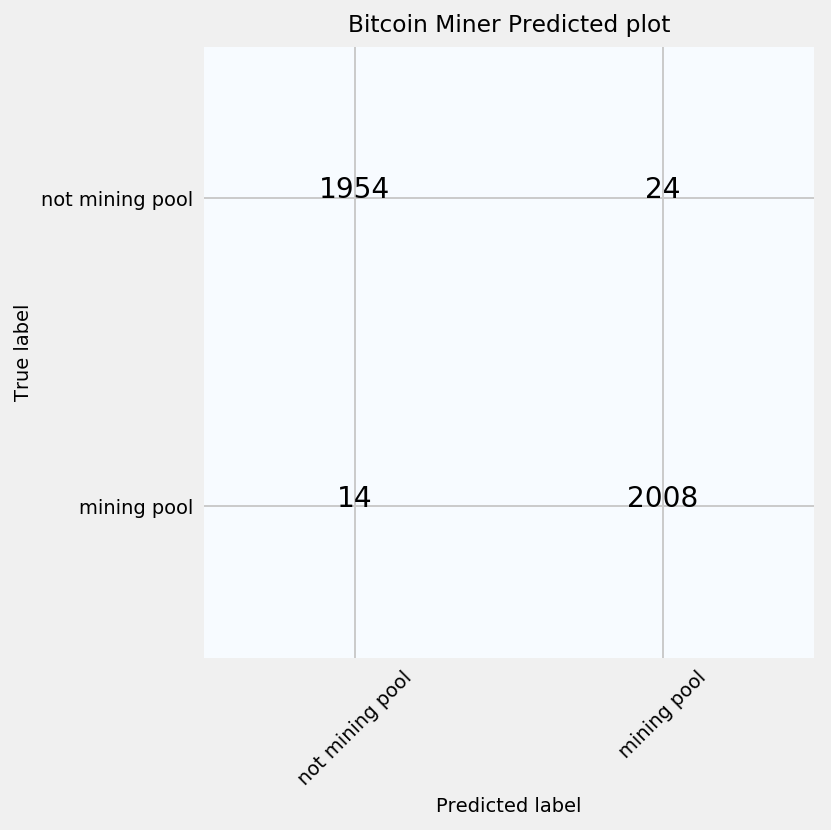

In [57]:
 def plot_confusion_matrix(cm, classes, normalize = False, title = 'Visualized Confusion matrix', cmap = plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    dummy = np.array([[0, 0], [0, 0]])
    plt.figure(figsize = (6, 6))
    plt.imshow(dummy, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['not mining pool', 'mining pool']
np.set_printoptions(precision = 2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize = False, title = 'Bitcoin Miner Predicted plot')

plt.show()

In [58]:
accuracy_rate = (cnf_matrix[0][0] + cnf_matrix[1][1]) / (cnf_matrix[0][0] + cnf_matrix[1][1] + cnf_matrix[0][1] + cnf_matrix[1][0])


In [59]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("___________Random-Forest-Classifier_____________")
# print("\nReport: ", classification_report(X_test,y_pred.round()))
print("\n\t\tAccuracy:  {}%".format(accuracy_rate*100))

___________Random-Forest-Classifier_____________

		Accuracy:  99.05000000000001%


___

* ## Predict Miner using KNN Classification Algorithm...

In [60]:
# KNN Implementations

import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier()  
model.n_neighbors = 3
# fit the model with the training data
model.fit(X_train,y_train)

# Number of Neighbors used to predict the target
print('\nThe number of neighbors used to predict the target : ',model.n_neighbors)

# predict the target on the train dataset
predict_train = model.predict(X_train)
print('\nTarget on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : {} %'.format(accuracy_train*100))

# predict the target on the test dataset
predict_test = model.predict(X_test)
print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : {}%'.format(accuracy_test*100))


The number of neighbors used to predict the target :  3

Target on train data [False False  True ...  True False  True]
accuracy_score on train dataset : 98.4 %
Target on test data [ True False  True ... False  True  True]
accuracy_score on test dataset : 97.7%


In [61]:
from sklearn.metrics import classification_report
print("\n\t\t\t______Report_____\n\n",classification_report(y_test, y_pred))
print("\n_____Confusion Matrix______\n\n",confusion_matrix(y_test, y_pred) )




			______Report_____

               precision    recall  f1-score   support

       False       0.99      0.99      0.99      1978
        True       0.99      0.99      0.99      2022

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000


_____Confusion Matrix______

 [[1954   24]
 [  14 2008]]


___

* ## Prediction using LSTM

 > Importing Required Modules

In [62]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

> Imports Required

In [70]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

> Assigning  LSTM model 

In [71]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [172]:

lr = 0.001
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.55))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))
rmsprop = optimizers.RMSprop(lr)

# regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    
regressor.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['binary_accuracy'])
history = regressor.fit(X_train, y_train, epochs = 200, batch_size = 800)



Epoch 1/200
6000/6000 [==============================] - 20s 3ms/step - loss: 2.1906 - binary_accuracy: 0.5037
Epoch 2/200
6000/6000 [==============================] - 2s 267us/step - loss: 1.0243 - binary_accuracy: 0.5055
Epoch 3/200
6000/6000 [==============================] - 2s 258us/step - loss: 0.7103 - binary_accuracy: 0.5717
Epoch 4/200
6000/6000 [==============================] - 2s 261us/step - loss: 0.7015 - binary_accuracy: 0.6162
Epoch 5/200
6000/6000 [==============================] - 2s 261us/step - loss: 0.6346 - binary_accuracy: 0.6443
Epoch 6/200
6000/6000 [==============================] - 2s 268us/step - loss: 0.6013 - binary_accuracy: 0.7617
Epoch 7/200
6000/6000 [==============================] - 2s 261us/step - loss: 0.5802 - binary_accuracy: 0.7858
Epoch 8/200
6000/6000 [==============================] - 2s 266us/step - loss: 0.7041 - binary_accuracy: 0.6407
Epoch 9/200
6000/6000 [==============================] - 2s 265us/step - loss: 0.5869 - binary_accuracy: 

6000/6000 [==============================] - 2s 268us/step - loss: 0.6632 - binary_accuracy: 0.6247
Epoch 74/200
6000/6000 [==============================] - 2s 270us/step - loss: 0.6581 - binary_accuracy: 0.6483
Epoch 75/200
6000/6000 [==============================] - 2s 267us/step - loss: 0.6519 - binary_accuracy: 0.6595
Epoch 76/200
6000/6000 [==============================] - 2s 264us/step - loss: 0.6449 - binary_accuracy: 0.6742
Epoch 77/200
6000/6000 [==============================] - 2s 266us/step - loss: 0.6311 - binary_accuracy: 0.6817
Epoch 78/200
6000/6000 [==============================] - 2s 261us/step - loss: 0.6299 - binary_accuracy: 0.6845
Epoch 79/200
6000/6000 [==============================] - 2s 266us/step - loss: 0.6162 - binary_accuracy: 0.7023
Epoch 80/200
6000/6000 [==============================] - 2s 263us/step - loss: 0.6027 - binary_accuracy: 0.7180
Epoch 81/200
6000/6000 [==============================] - 2s 266us/step - loss: 0.6093 - binary_accuracy: 0.7

6000/6000 [==============================] - 2s 264us/step - loss: 0.3786 - binary_accuracy: 0.6713
Epoch 146/200
6000/6000 [==============================] - 2s 265us/step - loss: 0.3816 - binary_accuracy: 0.6952
Epoch 147/200
6000/6000 [==============================] - 2s 263us/step - loss: 0.4112 - binary_accuracy: 0.6743
Epoch 148/200
6000/6000 [==============================] - 2s 261us/step - loss: 0.3769 - binary_accuracy: 0.7248
Epoch 149/200
6000/6000 [==============================] - 2s 265us/step - loss: 0.3878 - binary_accuracy: 0.7377
Epoch 150/200
6000/6000 [==============================] - 2s 266us/step - loss: 0.3551 - binary_accuracy: 0.7428
Epoch 151/200
6000/6000 [==============================] - 2s 268us/step - loss: 0.3548 - binary_accuracy: 0.7378
Epoch 152/200
6000/6000 [==============================] - 2s 264us/step - loss: 0.3441 - binary_accuracy: 0.7292
Epoch 153/200
6000/6000 [==============================] - 2s 264us/step - loss: 0.3416 - binary_accur

In [173]:
regressor.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 26, 50)            10400     
_________________________________________________________________
dropout_89 (Dropout)         (None, 26, 50)            0         
_________________________________________________________________
lstm_90 (LSTM)               (None, 26, 50)            20200     
_________________________________________________________________
dropout_90 (Dropout)         (None, 26, 50)            0         
_________________________________________________________________
lstm_91 (LSTM)               (None, 26, 50)            20200     
_________________________________________________________________
dropout_91 (Dropout)         (None, 26, 50)            0         
_________________________________________________________________
lstm_92 (LSTM)               (None, 50)                20200     
__________

> Building the Confusion Matrix

In [174]:
print("\n.....Confusion-Matrix of LSTM....\n\n", confusion_matrix(y_test, y_pred))


.....Confusion-Matrix of LSTM....

 [[1954   24]
 [  14 2008]]


In [175]:
# Testing Accuracy
scores = regressor.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: {}%" .format(scores[1]*100))

Accuracy: 88.625%


In [ ]:
# # summarize history for accuracy

# ['acc', 'val_acc','loss','val_loss']
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['X_train', 'X_test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [177]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=['LSTM Model', 'KNN-Classification','Random Forest Classification']),
                 cells=dict(values=["Accuracy: {}%" .format(scores[1]*100), 'Accuracy: {}%'.format(accuracy_test*100),"Accuracy:  {}%".format(accuracy_rate*100)]))
                     ])

fig.update_layout(width=1000, height=300)
fig.update_layout(
    title=go.layout.Title(
        text="Fig: Accuracy Comparision between different Machine Learning algorithms",
        xref="paper",
        x=0))
fig.show()